### makemore: lect03


### day14

- 202403120630--202403120800
- 202403122000--202403122100

### day 15
- 202403130845--202403131200
  
### day 16
- 202403140630--202403140800

### day 17
- 202403152100--202403152130


### day 18
- 202403161300--202403161500

  
### day 19
- 202403170900--202403171215
- 

In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Any

### Constants

In [64]:
RANDOM_SEED = 10
NUM_BLOCKS = 3
NUM_DIM_CHARS = 2
NUM_HIDDEN = 20

### Random Generator

In [65]:
import random
import numpy as np

rand_gen = torch.Generator().manual_seed(RANDOM_SEED)
RAND_GEN = rand_gen

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Read File

In [66]:
words = open("names.txt").read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

### Make Mappings: `chr -> int` and `int -> chr`

In [67]:
ord("a"), ord("z"), ord("z") - ord("a") + 1, chr(ord("a")), chr(ord("z"))

(97, 122, 26, 'a', 'z')

In [70]:
itos = {i - ord("a") + 1: chr(i) for i in range(ord("a"), ord("z") + 1)}
itos[0] = "."

stoi = {s: i for i, s in itos.items()}

# stoi
# itos

In [71]:
chars = sorted(list(set("".join(words))))
chars[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [72]:
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

### Get Data

In [73]:
def get_data(words: List[str], num_blocks: int = 3, stoi=stoi) -> (List[torch.tensor], List[torch.tensor]):
    """get data"""

    X, Y = [], []


    # ## tese lines are for testing:
    # for word in words[:5]:
    #     print("-" * 80)

    for word in words:
        context = [0] * num_blocks
        for ch in word + ".":
            i = stoi[ch]
            # append the current char ch, i.e. the index i into Y;
            # at the same time append the current context into X;
            # (the context up to now) contains letters that preeced the char ch
            # print(" ".join((itos[ix] for ix in context)), "--->", ch)
            X.append(context)
            Y.append(i)
            context = context[1: ] + [i]
           

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [74]:
get_data(words)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [11]:
num_blocks = NUM_BLOCKS
X, Y = get_data(words, num_blocks=num_blocks)

In [12]:
X[:10]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]])

In [13]:
Y[:10]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])

### Split Data: `train`, `val/dev`, and `test`

In [14]:
X.shape, X.shape[0]

(torch.Size([228146, 3]), 228146)

In [15]:
Y.shape, Y.shape[0]

(torch.Size([228146]), 228146)

In [16]:
indexes = torch.randperm(X.shape[0], generator=rand_gen)
indexes[:10]

tensor([117017,  81926, 152774,   8097, 220660,  38770, 226753, 147220, 224337,
        175417])

In [17]:
# this list changes over time?!
torch.randperm(X.shape[0], generator=rand_gen)[:10]

tensor([184694,  31158,  21725,  15842,   3894,  75184,  50599, 156241, 116075,
         47106])

In [75]:
def split_data(X, y, split=0.8):
    
    """split data into train, val, and test sets"""
    
    assert X.shape[0] == y.shape[0], "input data X and Y sizes do not match."
    assert (0 < split and split < 1), "the split for training data should be within (0, 1)."
    
    len_data = X.shape[0]
    shuffled_indices = torch.randperm(X.shape[0], generator=rand_gen)

    len_train = int(split * len_data)
    len_val = (len_data - len_train) // 2
    len_test = len_data - len_train - len_val
    
    
    X_train = X[shuffled_indices][:len_train]
    X_val = X[shuffled_indices][len_train: len_train + len_val]
    X_test = X[shuffled_indices][- len_test:]
    
    y_train = Y[shuffled_indices][:len_train]
    y_val = Y[shuffled_indices][len_train: len_train + len_val]
    y_test = Y[shuffled_indices][- len_test:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [76]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

In [77]:
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([22815, 3]),
 torch.Size([22815, 3]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

### MLP revisted

### Develop Model

- `C` is a mapping that translates `chars` into a `dim`-dimensional vector space;

In [78]:
### given the context X; 
### we predict the following char given in Y; 
### and the prediction belongs in one out of 27 classes; 
### i.e. there are 27 chars as a possibility for it. 

vocab_size = 27 

In [123]:
# MLP revisted
n_embed = 10 # the dimensionality of the char. embedding 
n_hidden = 200 # the number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * num_blocks, n_hidden), generator=g) * (5 /3) / ((n_embed * num_blocks) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.2
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

12297


### Pay attention about shapes

In [80]:
torch.randn((5, ), generator=rand_gen)

tensor([ 1.1329,  0.3249,  0.1838,  0.3746, -0.2744])

In [81]:
torch.randn(5, generator=rand_gen)

tensor([ 2.2780, -0.1322, -1.4547,  0.2755,  0.5909])

In [82]:
torch.randn((5, 1), generator=rand_gen)

tensor([[ 0.9375],
        [ 1.5414],
        [-1.5006],
        [ 0.1918],
        [ 0.9503]])

### Optimization

In [83]:
X_train.shape[0]

182516

In [84]:
# mini-batch construct
batch_size = 32
ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
# print(i, ix)
X_batch, Y_batch = X_train[ix], Y_train[ix]
X_batch.shape, C.shape

(torch.Size([32, 3]), torch.Size([27, 10]))

In [85]:
# C: 27 x 10 
# X_batch: 32 x 3 

emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [86]:
emb.view(emb.shape[0], -1).shape

torch.Size([32, 30])

In [87]:
X_batch

tensor([[18,  9, 20],
        [ 0,  0,  5],
        [ 1, 14, 25],
        [ 0,  0, 10],
        [22, 15, 14],
        [11,  5, 14],
        [ 0, 20,  1],
        [14, 11,  9],
        [ 0,  0,  0],
        [ 0,  0, 11],
        [ 0,  0,  0],
        [ 1,  5,  8],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [19, 21, 11],
        [22,  5, 14],
        [20,  1, 12],
        [ 4,  5,  5],
        [12,  1, 14],
        [ 1, 22,  5],
        [ 0,  0,  0],
        [ 0, 14,  1],
        [12, 25,  1],
        [12,  5,  5],
        [ 4, 15, 18],
        [ 0,  0,  5],
        [ 0,  0, 18],
        [ 5, 12,  1],
        [13,  5, 12],
        [ 5, 14,  3],
        [11,  5,  9],
        [10,  1,  8]])

In [88]:
C.shape

torch.Size([27, 10])

In [89]:
C[0].shape

torch.Size([10])

In [90]:
C[X_batch[2]].shape

torch.Size([3, 10])

In [91]:
X_batch[2]

tensor([ 1, 14, 25])

In [92]:
C[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)

In [93]:
C[19]

tensor([-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
        -0.4528, -0.4958], grad_fn=<SelectBackward0>)

In [94]:
C[5]

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830], grad_fn=<SelectBackward0>)

In [95]:
C[[0, 19, 5]]

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
         -0.4528, -0.4958],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830]], grad_fn=<IndexBackward0>)

In [96]:
C[X_batch[2]]

tensor([[-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [ 4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01],
        [-1.2801e+00,  9.2445e-02,  1.0526e-01, -3.9072e-01,  3.1723e-02,
         -5.4753e-01,  8.1827e-01, -8.1628e-01, -3.9243e-01, -7.4521e-01]],
       grad_fn=<IndexBackward0>)

In [97]:
emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [98]:
emb_cat = emb.view(emb.shape[0], -1)
emb_cat.shape

torch.Size([32, 30])

In [99]:
W1.shape

torch.Size([30, 200])

In [100]:
h = emb_cat @ W1 + b1
h.shape

torch.Size([32, 200])

In [101]:
W2.shape

torch.Size([200, 27])

In [102]:
(h @ W2).shape

torch.Size([32, 27])

In [103]:
b2.shape

torch.Size([27])

In [104]:
Y_batch.shape

torch.Size([32])

In [105]:
X.shape

torch.Size([228146, 3])

In [109]:
logits = h @ W2 + b2
probs_test = F.softmax(logits)
probs = F.softmax(logits, dim=1)

/tmp/ipykernel_80299/1051215198.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs_test = F.softmax(logits)


In [110]:
X_batch.shape, emb.shape, emb_cat.shape, W1.shape, hpreact.shape, W2.shape, logits.shape

(torch.Size([32, 3]),
 torch.Size([32, 3, 10]),
 torch.Size([32, 30]),
 torch.Size([30, 200]),
 torch.Size([32, 200]),
 torch.Size([200, 27]),
 torch.Size([32, 27]))

In [111]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [112]:
hpreact.mean(0, keepdim=True)[0][0], hpreact[:,0].sum()/32

(tensor(1.4901e-08, grad_fn=<SelectBackward0>),
 tensor(-3.7253e-09, grad_fn=<DivBackward0>))

In [113]:
hpreact.mean(1, keepdim=True).shape

torch.Size([32, 1])

In [114]:
hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [115]:
hpreact.mean(0, keepdim=True)

tensor([[ 1.4901e-08,  1.4901e-08,  0.0000e+00,  1.1176e-08, -4.4703e-08,
         -1.4901e-08,  1.4901e-08, -2.9802e-08,  1.8626e-09, -2.9802e-08,
         -5.9605e-08,  1.7695e-08, -3.3528e-08,  1.4901e-08, -6.7055e-08,
          7.4506e-09,  7.4506e-09,  0.0000e+00,  3.7253e-08, -1.4901e-08,
          1.4901e-08, -3.7253e-09,  4.4703e-08, -1.4901e-08, -1.4901e-08,
         -4.4703e-08,  3.7253e-09,  7.4506e-09,  7.4506e-09,  6.7055e-08,
         -3.7253e-08, -2.2352e-08,  7.4506e-09, -1.3039e-08, -1.4901e-08,
         -3.7253e-09,  0.0000e+00,  3.7253e-08,  2.9802e-08, -1.4901e-08,
         -2.9802e-08, -1.1176e-08,  0.0000e+00, -2.9802e-08,  0.0000e+00,
          2.9802e-08,  3.7253e-08,  0.0000e+00,  0.0000e+00,  7.4506e-09,
         -3.7253e-08,  7.4506e-09,  3.7253e-08, -2.9802e-08, -2.9802e-08,
          4.4703e-08, -1.3039e-08,  2.9802e-08,  6.5193e-09, -1.1176e-08,
          2.9802e-08,  1.4901e-08,  2.9802e-08, -5.9605e-08,  0.0000e+00,
         -1.4901e-08,  3.7253e-08,  2.

In [116]:
hpreact.std(0, keepdim=True)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0

In [125]:
max_steps = 5_000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # backward pass: 
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad
        
    
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())
    # break


    200 /    5000; 2.0967
    400 /    5000; 2.2503
    600 /    5000; 2.2082
    800 /    5000; 2.2965
   1000 /    5000; 2.5740
   1200 /    5000; 2.3457
   1400 /    5000; 2.6500
   1600 /    5000; 2.5167
   1800 /    5000; 2.1632
   2000 /    5000; 2.5433
   2200 /    5000; 2.3982
   2400 /    5000; 2.5609
   2600 /    5000; 2.4234
   2800 /    5000; 1.7956
   3000 /    5000; 2.7836
   3200 /    5000; 2.2964
   3400 /    5000; 2.1916
   3600 /    5000; 2.2808
   3800 /    5000; 1.9137
   4000 /    5000; 2.7400
   4200 /    5000; 2.1141
   4400 /    5000; 2.2793
   4600 /    5000; 2.0592
   4800 /    5000; 2.3175
   5000 /    5000; 2.0436


In [127]:
lossi[:10]

[2.628807783126831,
 2.1486830711364746,
 2.1276841163635254,
 2.475005865097046,
 2.5804107189178467,
 2.095093011856079,
 2.4205150604248047,
 2.280073404312134,
 2.1078922748565674,
 2.5922131538391113]

In [128]:
h, h.shape

(tensor([[ 0.5721, -0.6423,  0.0697,  ..., -0.6236,  0.3060,  0.5941],
         [-0.6726, -0.6732, -0.7369,  ...,  0.7530,  0.0398,  0.0166],
         [-0.9343,  0.7571, -0.3538,  ...,  0.5831, -0.3091, -0.4019],
         ...,
         [ 0.8903, -0.4310, -0.6672,  ...,  0.4802, -0.2618,  0.0731],
         [ 0.4658,  0.6119,  0.7533,  ..., -0.1675, -0.2714, -0.1648],
         [ 0.9282,  0.2848,  0.5427,  ..., -0.9293,  0.8182,  0.7009]],
        grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

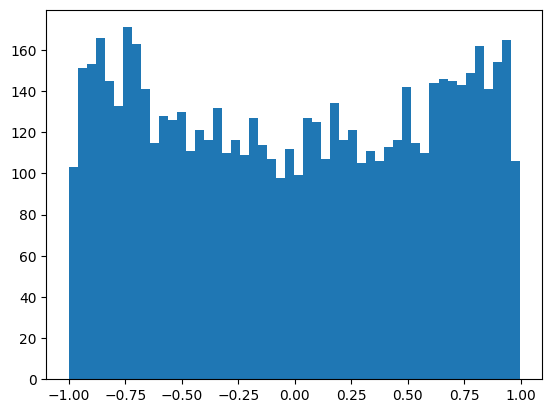

In [129]:
plt.hist(h.view(-1).tolist(), 50);

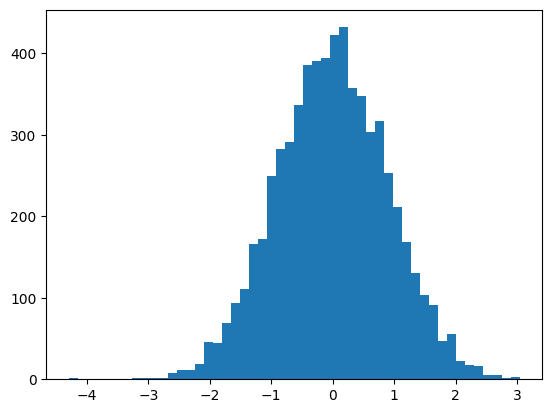

In [130]:
plt.hist(hpreact.view(-1).tolist(), 50);

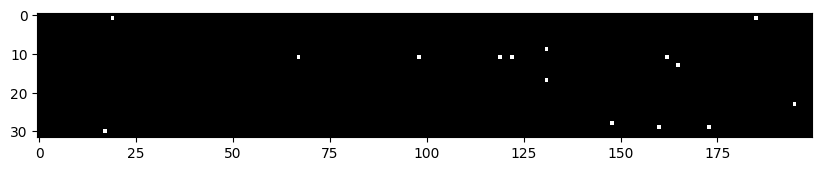

In [133]:
plt.figure(figsize=(10, 20))
plt.imshow(h.abs() >= 0.99, cmap="gray", interpolation="nearest")

### White = 1, True; and Black = 0 False;

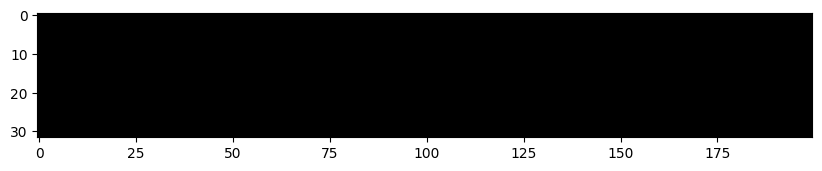

In [134]:
plt.figure(figsize=(10, 20))
plt.imshow(0 * h.abs() >= 0.99, cmap="gray", interpolation="nearest")

In [135]:
h.shape, hpreact.shape

(torch.Size([32, 200]), torch.Size([32, 200]))

In [136]:
lossi[:10]

[2.628807783126831,
 2.1486830711364746,
 2.1276841163635254,
 2.475005865097046,
 2.5804107189178467,
 2.095093011856079,
 2.4205150604248047,
 2.280073404312134,
 2.1078922748565674,
 2.5922131538391113]

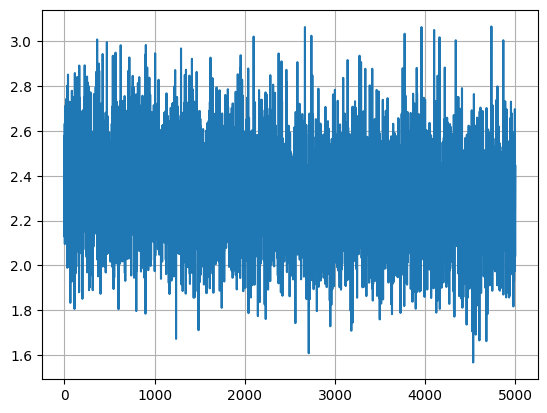

In [137]:
plt.plot(lossi)
plt.grid(True)

In [138]:
logits[0]

tensor([-2.2121,  2.8644, -0.5815, -1.6433, -1.1423,  2.5667, -1.3098, -1.8520,
         1.5163,  1.6451, -2.3154, -0.8356,  0.5088, -0.8477, -1.7514,  1.4575,
        -1.6509, -3.1851,  3.5115, -0.3805, -1.8211,  1.4851, -1.2376,  0.1413,
        -4.1027,  1.2074, -1.5471], grad_fn=<SelectBackward0>)

In [141]:
probs = torch.softmax(logits[0], dim=0)
probs.sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [142]:
probs = torch.softmax(logits, dim=1)

In [143]:
probs.shape

torch.Size([32, 27])

In [144]:
probs[0].shape, probs[0].sum(), probs[1].shape, probs[1].sum()

(torch.Size([27]),
 tensor(1.0000, grad_fn=<SumBackward0>),
 torch.Size([27]),
 tensor(1.0000, grad_fn=<SumBackward0>))

In [148]:
with torch.no_grad():
    emb = C[X_train]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [149]:
bnmean

tensor([[-0.9199, -0.3744, -1.1589,  0.7552,  0.9783,  0.4880,  1.6982, -0.8925,
         -0.1764,  0.7415, -0.9607, -1.3209, -0.0451, -0.1160, -0.1815,  0.4014,
          0.4220, -1.8760, -0.5117,  0.7324,  0.3257, -0.7424, -0.1377,  0.9897,
          0.3174,  0.0567,  0.7607,  0.2249, -0.2883,  1.0391,  0.0438, -0.8328,
          0.3261,  0.4191, -0.6040, -0.6782, -0.5943, -1.0706, -0.3699,  0.5030,
         -0.0827, -1.1216, -0.6653, -0.2443,  0.6788,  0.4853,  0.1985, -0.6306,
          0.9417,  1.3717,  0.2813,  0.4529,  1.4997,  1.4659,  0.8565, -1.1765,
          0.1499,  0.6055,  1.0270, -0.9159,  0.0289, -0.0991,  0.8428,  0.3499,
          1.0785,  0.8444,  1.0215,  0.4200, -0.4730, -0.0900, -0.6067,  0.8772,
          0.9187, -1.2243, -1.1374,  0.3582,  1.2062, -0.3729,  0.4206, -0.2413,
          0.7549,  0.8799,  1.1714,  0.5627,  0.4025, -0.6107, -1.3927,  0.0253,
          0.8182, -0.3332,  0.4655,  0.6180, -0.4756, -0.3513, -0.1275, -0.3301,
         -0.8851, -0.6090,  

In [150]:
bnmean_running

tensor([[-0.9251, -0.3757, -1.1695,  0.7557,  0.9650,  0.4966,  1.7044, -0.9156,
         -0.1973,  0.7270, -0.9449, -1.3270, -0.0518, -0.1165, -0.1745,  0.4039,
          0.4147, -1.8732, -0.5148,  0.7616,  0.3264, -0.7475, -0.1217,  0.9957,
          0.3281,  0.0639,  0.7695,  0.2338, -0.2932,  1.0471,  0.0389, -0.8268,
          0.3385,  0.4273, -0.6064, -0.6847, -0.6041, -1.0842, -0.3641,  0.5076,
         -0.0815, -1.1215, -0.6810, -0.2457,  0.6864,  0.4860,  0.1992, -0.6345,
          0.9457,  1.3870,  0.2883,  0.4478,  1.5012,  1.4650,  0.8675, -1.1723,
          0.1379,  0.6091,  1.0377, -0.9075,  0.0269, -0.0887,  0.8509,  0.3278,
          1.0828,  0.8358,  1.0201,  0.4190, -0.4802, -0.0918, -0.5926,  0.8803,
          0.9192, -1.2376, -1.1523,  0.3618,  1.2192, -0.3722,  0.4174, -0.2502,
          0.7634,  0.8831,  1.1713,  0.5712,  0.4057, -0.6074, -1.3907,  0.0235,
          0.8173, -0.3429,  0.4693,  0.6325, -0.4741, -0.3365, -0.1362, -0.3359,
         -0.8871, -0.5949,  

In [151]:
bnstd

tensor([[1.9059, 1.3207, 1.5639, 1.6633, 1.8433, 1.7204, 1.2804, 1.5438, 1.7337,
         1.3856, 1.6056, 1.6506, 1.6642, 2.0471, 1.1449, 1.5985, 2.3638, 1.3867,
         1.7585, 1.7335, 1.6244, 1.9120, 1.7287, 2.0754, 1.6264, 1.5057, 1.4230,
         1.5628, 2.2408, 2.0224, 1.2689, 1.5585, 2.3783, 1.5006, 2.1938, 1.4748,
         1.5461, 2.1187, 1.8533, 1.6906, 1.5893, 1.8538, 1.7509, 2.5304, 1.4344,
         2.1279, 1.7677, 2.0785, 1.3119, 1.9440, 1.4694, 1.5201, 1.3452, 1.7776,
         1.7605, 1.6734, 1.4138, 2.0903, 2.2521, 1.4168, 1.5226, 1.7040, 1.3114,
         1.6409, 1.9081, 1.8175, 1.7974, 1.4609, 1.6714, 1.9545, 1.8485, 1.8834,
         1.6000, 1.1506, 1.4947, 1.9421, 1.9741, 2.0783, 2.1037, 1.8422, 2.4714,
         1.5390, 1.6321, 2.0648, 1.9009, 1.7090, 1.6132, 1.6561, 1.8909, 1.6274,
         1.5288, 1.6420, 1.9332, 2.8305, 2.2398, 1.6385, 2.1017, 2.0702, 1.2358,
         1.7648, 1.6402, 1.8323, 2.4835, 1.2398, 1.6191, 1.4366, 1.7935, 1.7779,
         1.7433, 2.0460, 1.8

In [152]:
bnstd_running

tensor([[1.7478, 1.1079, 1.8597, 1.6285, 1.8738, 1.3139, 1.3072, 1.2364, 2.1800,
         1.4002, 1.7761, 1.6321, 1.4228, 1.4096, 1.0100, 1.2410, 2.1805, 1.5354,
         1.6408, 1.4056, 1.3699, 1.7666, 1.6813, 2.1931, 1.3858, 1.4643, 1.3675,
         1.4349, 1.7254, 1.6136, 1.4556, 1.0854, 1.8650, 1.4556, 1.7520, 1.4891,
         1.3792, 2.0253, 1.2916, 1.8252, 1.2047, 1.9557, 1.5721, 2.3367, 1.1670,
         1.1183, 1.2937, 1.5472, 0.9374, 1.5517, 1.3816, 0.9475, 1.3855, 1.6600,
         1.7360, 1.5585, 1.4320, 1.9276, 2.5498, 1.2389, 1.1676, 1.2782, 1.3566,
         1.4667, 2.1633, 1.4133, 1.5808, 1.2693, 1.5814, 1.8216, 1.3953, 1.9506,
         1.4815, 0.8741, 1.2959, 1.3599, 1.4968, 1.3734, 1.6445, 1.3780, 1.5200,
         1.7221, 1.7275, 1.8727, 1.5010, 1.6231, 1.2720, 1.4550, 1.3576, 1.1785,
         1.4685, 1.5016, 1.7163, 2.3645, 1.7619, 1.4803, 1.9797, 1.6619, 1.2363,
         1.3580, 1.3575, 1.3990, 1.7736, 1.1283, 1.7637, 0.9451, 1.8024, 1.4942,
         1.6665, 2.0210, 1.2

In [153]:
@torch.no_grad()
def evaluate(split: str):

    data_map = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }
   
    x, y = data_map[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    print(f"{split = }, {loss.item() = }")

In [154]:
evaluate("train")    
evaluate("val")    
evaluate("test")    

split = 'train', loss.item() = 2.2410805225372314
split = 'val', loss.item() = 2.244424343109131
split = 'test', loss.item() = 2.244248628616333


In [155]:
# sample from the model 
rg = torch.Generator().manual_seed(RANDOM_SEED + 10)

for t in range(20):
    out = []
    context = [0] * NUM_BLOCKS
    while True:
        # emb = C[torch.tensor([context])]
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs_test = F.softmax(logits)
        probs = F.softmax(logits, dim=1)
    
        ix = torch.multinomial(probs, num_samples=1, generator=rg)
        ch = itos[ix.item()]
        # print(ch)  
        context = context[1:] + [ix]
        out.append(ix)
    
        if ix == 0:
            break
    print(t, "".join(itos[i.item()] for i in out))
    
    # print("".join()

0 kgwydvand.
1 gumbrwoxtrvwigs.
2 brckiffylah.
3 frvubder.
4 fmbrdyndh.
5 chllegghymbrkkovavphordvgbtxvfdgnovgqtizghstandylv.
6 dhv.
7 broxadviddopkyvskevdshdyngxhnlengbrulxxsstfvkcingtush.
8 zhlyxxmolgwhmmprdvkulajlixxjdzedghkkess.
9 ngulslmaczfxrngxrrckomerfuyxghvdrgjon.
10 caqmylidgbstum.
11 glorgjadduckatelle.
12 ujckyslax.
13 rmbrbugluckevzkkmkyling.
14 grrynverlaxdlwyxsmigbhskhmordynghuvajlossidgnny.
15 whlzex.
16 bmbingbrcxfilandambbbbbdqduwnstgwiloh.
17 degungbubhndussckqyndq.
18 jaxxrzkgudah.
19 sarvigghbrundrosdfffxchyl.


/tmp/ipykernel_80299/1897569945.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs_test = F.softmax(logits)


In [156]:
emb = C[torch.tensor(context)]

In [157]:
emb.shape

torch.Size([3, 10])

In [158]:
emb.view(1, -1).shape

torch.Size([1, 30])

In [159]:
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [162]:
probs.shape

torch.Size([1, 27])

In [163]:
probs.shape

torch.Size([1, 27])

In [166]:
probs.sum()

tensor(1., grad_fn=<SumBackward0>)

In [167]:
logits.shape

torch.Size([1, 27])

In [168]:
logits = torch.tensor([100.0, 0.0, 0.0, 0.0])
logits = torch.rand(4) * 100
probs = torch.softmax(logits, dim=0)

In [169]:
probs

tensor([1.5287e-07, 1.8203e-06, 7.2707e-14, 1.0000e+00])

In [170]:
loss = - probs[2].log()

In [171]:
logits, probs, loss

(tensor([45.8085, 48.2857, 31.2498, 61.5022]),
 tensor([1.5287e-07, 1.8203e-06, 7.2707e-14, 1.0000e+00]),
 tensor(30.2523))

In [172]:
torch.randn(10).shape

torch.Size([10])

In [173]:
for i in range(10):
    r = torch.randn(100)
    print(# r.mean().item(), 
          r.std().item())

0.8959280252456665
1.0698953866958618
0.9664099812507629
1.1011399030685425
0.8539541959762573
0.9838457107543945
1.0581798553466797
0.8983544111251831
1.0232785940170288
1.009940505027771


### day 17

In [177]:
class Linear:
        
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.randn(fan_out) if (bias is not None) else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=10**(-5), momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.dim = dim

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training: 
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_std

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # print("-" * 80)
        # print(f"{xhat.shape = }")
        # print(f"{self.gamma.shape = }")
        # print(f"{self.beta.shape = }")    
        
        self.out = self.gamma * xhat + self.beta
        
        with torch.no_grad():
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
    
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [178]:
vocab_size, n_embed, num_blocks

(27, 10, 3)

In [179]:
C = torch.randn((vocab_size, n_embed), generator=g)

# this is without batch normalization
layers = [
    Linear(num_blocks * n_embed, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

# this is with batch normalization
layers = [
    Linear(num_blocks * n_embed, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]


In [180]:
# layers[-1].weight *= 0.1
layers[-1].gamma *= 0.1
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 0.75 # 5/3 # 1 # 3

In [181]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

In [182]:
sum(p.nelement() for p in parameters)

174751

### optimization

In [183]:
max_steps = 500
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # forward pass
    x = emb_cat
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Y_batch) # loss function


    # backward pass: 
    for layer in layers:
        layer.out.retain_grad()
        
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    with torch.no_grad():
        ud.append(
            [(lr * p.grad).std() / p.data.std().log10().item() for p in parameters]
            # lr * p.grad / p.data
        )
        
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())
    break


In [184]:
loss

tensor(3.2939, grad_fn=<NllLossBackward0>)

In [185]:
x.shape

torch.Size([32, 27])

In [186]:
print(f"{len(layers) = }")
[type(layer) for layer in layers]

len(layers) = 17


[__main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d]

### Visualize Tanh Outs

layer 2; name: Tanh; mean -0.0032; std: 0.6270; saturated: 13.27%
layer 5; name: Tanh; mean 0.0007; std: 0.6312; saturated: 13.53%
layer 8; name: Tanh; mean 0.0033; std: 0.6347; saturated: 13.45%
layer 11; name: Tanh; mean 0.0004; std: 0.6342; saturated: 13.09%
layer 14; name: Tanh; mean 0.0014; std: 0.6296; saturated: 13.78%


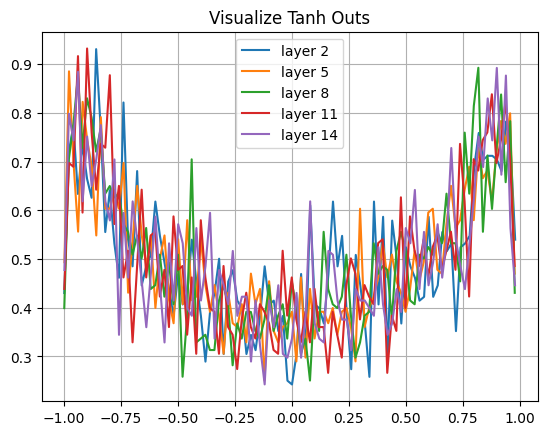

In [187]:
plt.close()
plt.grid(True)
for cnt, layer in enumerate(layers):
    # print(cnt, layer.out.shape, isinstance(layer, Tanh))
    if isinstance(layer, Tanh):
        t = layer.out
        saturated = (t.abs() > 0.90).float().mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; mean {t.mean():0.4f}; std: {t.std():0.4f}; saturated: {100 * saturated:0.2f}%")
        hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        plt.title("Visualize Tanh Outs")
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break
plt.legend()


### Visualize Tanh Grads

layer 2; name: Tanh; mean -0.0000; std: 0.0006; saturated: 0.00%
layer 5; name: Tanh; mean -0.0000; std: 0.0005; saturated: 0.00%
layer 8; name: Tanh; mean 0.0000; std: 0.0004; saturated: 0.00%
layer 11; name: Tanh; mean 0.0000; std: 0.0004; saturated: 0.00%
layer 14; name: Tanh; mean 0.0000; std: 0.0003; saturated: 0.00%


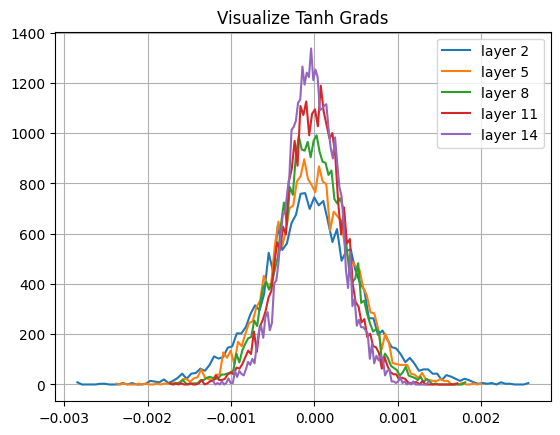

In [188]:
plt.close()
plt.grid(True)
for cnt, layer in enumerate(layers):
    # print(cnt, layer.out.shape, isinstance(layer, Tanh))
    if isinstance(layer, Tanh):
        t = layer.out.grad
        saturated = (t.abs() > 0.90).float().mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; mean {t.mean():0.4f}; std: {t.std():0.4f}; saturated: {100 * saturated:0.2f}%")
        hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        plt.title("Visualize Tanh Grads")
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break
plt.legend()

In [189]:
t.detach()

tensor([[-8.7010e-05,  3.4312e-04, -4.0875e-04,  ...,  2.4329e-04,
          2.6929e-04, -1.3697e-04],
        [-2.4008e-04, -3.4270e-04, -1.1629e-04,  ..., -9.1072e-05,
          6.3454e-05, -1.6036e-04],
        [ 2.3777e-05, -9.8523e-05, -1.8669e-04,  ..., -3.9126e-04,
         -1.5060e-04, -4.9062e-04],
        ...,
        [-1.4591e-04, -3.0147e-04, -4.5519e-05,  ..., -1.1977e-04,
          7.5932e-05, -2.3239e-04],
        [ 3.5743e-04, -3.0335e-04, -2.5830e-04,  ..., -3.8493e-04,
          3.6907e-04,  1.1785e-04],
        [-1.2125e-03,  2.0692e-04, -3.6615e-04,  ...,  1.7557e-04,
          6.9335e-06, -4.5459e-04]])

In [190]:
(t.abs() > 0.9)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [191]:
(t.abs() > 0.9).float().mean()

tensor(0.)

In [192]:
layer.__class__?

Init signature: layer.__class__(dim, eps=1e-05, momentum=0.1)
Docstring:      <no docstring>
Type:           type
Subclasses:     

In [193]:
layer.__class__.__dict__

mappingproxy({'__module__': '__main__',
              '__init__': <function __main__.BatchNorm1d.__init__(self, dim, eps=1e-05, momentum=0.1)>,
              '__call__': <function __main__.BatchNorm1d.__call__(self, x)>,
              'parameters': <function __main__.BatchNorm1d.parameters(self)>,
              '__dict__': <attribute '__dict__' of 'BatchNorm1d' objects>,
              '__weakref__': <attribute '__weakref__' of 'BatchNorm1d' objects>,
              '__doc__': None})

In [194]:
layer.__class__.__name__

'BatchNorm1d'

### Visualize Parameters: Grad to Data Ratio

In [198]:
# plt.close()

for cnt, p in enumerate(parameters):
    if p.dim() == 2:
        t = p.grad.mean() / p.data.mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; shape: {p.shape}; mean {p.mean():0.4f}; std: {p.std():0.4f}; grad:data ratio: {p.grad.mean() / p.data.mean():0.2f}%")
        # hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        # plt.title("Visualize Tanh Grads")
        # plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break

# plt.grid(True)
# plt.legend()


layer 0; name: BatchNorm1d; shape: torch.Size([27, 10]); mean -0.0105; std: 1.0342; grad:data ratio: 0.00%
layer 1; name: BatchNorm1d; shape: torch.Size([30, 200]); mean 0.0006; std: 0.1384; grad:data ratio: -0.00%
layer 5; name: BatchNorm1d; shape: torch.Size([200, 200]); mean 0.0000; std: 0.0533; grad:data ratio: -0.74%
layer 9; name: BatchNorm1d; shape: torch.Size([200, 200]); mean 0.0003; std: 0.0528; grad:data ratio: -0.00%
layer 13; name: BatchNorm1d; shape: torch.Size([200, 200]); mean -0.0003; std: 0.0531; grad:data ratio: -0.03%
layer 17; name: BatchNorm1d; shape: torch.Size([200, 200]); mean -0.0000; std: 0.0532; grad:data ratio: 3.15%
layer 21; name: BatchNorm1d; shape: torch.Size([200, 27]); mean -0.0011; std: 0.0537; grad:data ratio: 0.01%


In [199]:
len(parameters)

25

### This does not work!

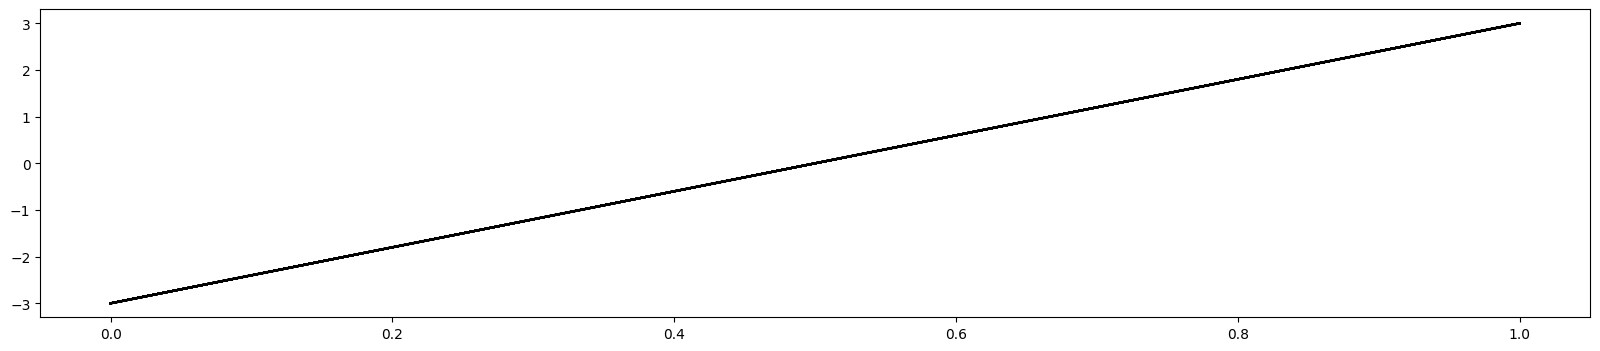

In [200]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.dim == 2:
        # plt.plot([ud[j][i] for j in range(len(ud))])
        plt.plot(ud[i])
        
    plt.plot([0, len(ud)], [-3, 3], "k")
plt.show()

### 202404009072500--??

In [203]:
DEBUG = False
# -------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5) ## kaiming init
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if (self.bias is not None):
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if (self.bias is None) else [self.bias])

# -------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps=10**(-5), momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if x.ndim == 2:
            dim = 0
        elif x.ndim == 3:
            dim = (0, 1)
        
        if self.training:
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if DEBUG:
            zz = torch.sqrt(xvar) #  + self.eps)
            
            print(f"{x.shape = }")
            print(f"{xmean.shape = }")
            print(f"{xvar.shape = }")
            print(f"{xhat.shape = }")
            print(f"{self.gamma.shape = }")
            print(f"{self.beta.shape = }")
            print(f"{self.out.shape = }")
            print(f"{zz.shape = }")
            
            print(f"{self.eps = }")
            print(f"{x = }")
            print(f"{xmean = }")
            print(f"{xvar = }")
            print(f"{xhat = }")
            print(f"{zz = }")
            print(f"{self.gamma = }")
            print(f"{self.beta = }")
            print(f"{self.out = }")

        # update buffers: 
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.beta, self.gamma]


# -------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []

# -------------------------------------------------
class Embedding:
    # def __init__(self, vocab_size, n_embed):
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, indexes):
        self.out = self.weight[indexes]
        return self.out
        
    def parameters(self):
        return [self.weight]

# -------------------------------------------------
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
        
    def parameters(self):
        return []


# -------------------------------------------------
class FlattenConsequtive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out
        
    def parameters(self):
        return []


# -------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # return parameters
        return [p for layer in self.layers for p in layer.parameters()]
        

In [204]:
torch.manual_seed(42)

### define a network as a list of layers:

In [205]:
# MLP revisted
n_embed = 10 # the dimensionality of the char. embedding 
n_hidden = 200 # the number of neurons in the hidden layers

In [206]:
C = torch.randn((vocab_size, n_embed))

In [207]:
C.shape

torch.Size([27, 10])

In [208]:
layers = [
    Linear(fan_in=num_blocks * n_embed, fan_out=n_hidden, bias=True),
    BatchNorm1d(dim=n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=vocab_size, bias=True),    
]

In [209]:
layers

In [210]:
# make the last layer less confident
with torch.no_grad():
    layers[-1].weights *= 0.1

In [211]:
# parameters = [C] + [p for p in layer for layer in layers]
# parameters = [C] + [p for p in layer.paparameters() for layer in layers]

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

In [212]:
len(parameters)

7

In [213]:
[p.nelement() for p in parameters]

[270, 6000, 200, 200, 200, 5400, 27]

In [214]:
sum((p.nelement() for p in parameters))

12297

In [215]:
layers

In [216]:
C.nelement

<function Tensor.nelement>

In [217]:
layers[0]

In [218]:
layers[0].weights.nelement(), layers[0].bias.nelement()

(6000, 200)

In [219]:
layers[1]

In [220]:
layers[1].parameters()

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.,

In [225]:
layers[1].gamma.nelement(), layers[1].beta.nelement()

(200, 200)

In [226]:
layers[2]

In [227]:
layers[2].parameters()

[]

In [228]:
layers[3]

In [229]:
layers[3].weights

tensor([[-0.0080,  0.0064,  0.0010,  ..., -0.0045, -0.0002, -0.0020],
        [ 0.0027, -0.0224,  0.0074,  ..., -0.0008,  0.0044,  0.0087],
        [ 0.0051, -0.0028, -0.0043,  ...,  0.0046, -0.0133,  0.0093],
        ...,
        [ 0.0025,  0.0041, -0.0002,  ...,  0.0081, -0.0119,  0.0004],
        [-0.0051, -0.0019, -0.0107,  ...,  0.0088, -0.0016,  0.0158],
        [ 0.0008,  0.0098, -0.0062,  ..., -0.0024,  0.0026,  0.0035]],
       requires_grad=True)

In [230]:
layers[3].weights.nelement(), layers[3].bias.nelement()

(5400, 27)

### Training: 

In [231]:
X_train.size(), Y_train.size()

(torch.Size([182516, 3]), torch.Size([182516]))

In [232]:
len_data = X_train.shape[0]
print(len_data)

182516


In [233]:
max_steps = 50_000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(len_data)[:batch_size]
    # print(f"{ix = }")
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    emb_cat = emb.view(emb.shape[0], -1)
    if DEBUG:
        print(f"{emb.shape = }")
        print(f"{emb = }")
        print(f"{emb_cat.shape = }")
        
    x = emb_cat
    for layer in layers:
        x = layer(x)
        if DEBUG:
            print("-" * 80)
            print(f"{layer = }")
            print(f"{x.sxhape = }")
            print(f"{x = }")
            
    loss = F.cross_entropy(x, Yb)

    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()


    # update rule: 
    lr = 0.1 if (i < max_steps * 0.5) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # stats
    if (i + 1) % (max_steps // 50) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
        
    # store loss
    lossi.append(loss.detach().item())

   1000 /   50000; 3.2711
   2000 /   50000; 2.6396
   3000 /   50000; 2.9995
   4000 /   50000; 2.9100
   5000 /   50000; 3.0027
   6000 /   50000; 2.9122
   7000 /   50000; 2.9597
   8000 /   50000; 2.8479
   9000 /   50000; 2.8727
  10000 /   50000; 2.7210
  11000 /   50000; 3.1158
  12000 /   50000; 2.7722
  13000 /   50000; 3.0291
  14000 /   50000; 2.6308
  15000 /   50000; 2.7757
  16000 /   50000; 2.8341
  17000 /   50000; 2.9303
  18000 /   50000; 2.6518
  19000 /   50000; 2.6931
  20000 /   50000; 2.8830
  21000 /   50000; 2.5849
  22000 /   50000; 2.7491
  23000 /   50000; 2.7166
  24000 /   50000; 2.9426
  25000 /   50000; 2.7509
  26000 /   50000; 2.5935
  27000 /   50000; 2.7874
  28000 /   50000; 2.6220
  29000 /   50000; 2.7741
  30000 /   50000; 2.8775
  31000 /   50000; 2.9749
  32000 /   50000; 2.9753
  33000 /   50000; 2.6236
  34000 /   50000; 2.8877
  35000 /   50000; 2.7139
  36000 /   50000; 2.8162
  37000 /   50000; 2.8804
  38000 /   50000; 2.5969
  39000 /   

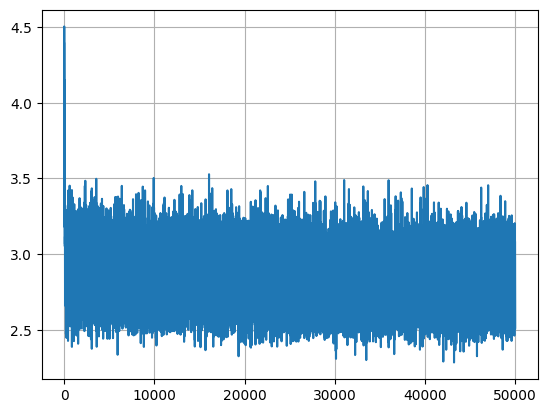

In [234]:
plt.plot(lossi)
plt.grid(True)

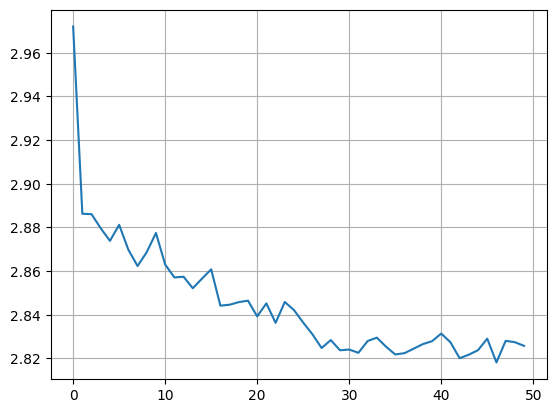

In [235]:
plt.plot(
    torch.FloatTensor(lossi).view(-1, 1000).mean(dim=1)
)
plt.grid(True)

### A second way after adding layers `Embedding` and `Flatten`

In [236]:
layers = [
    Embedding(num_embeddings=vocab_size, embedding_dim=n_embed),
    Flatten(),
    Linear(fan_in=num_blocks * n_embed, fan_out=n_hidden, bias=True),
    BatchNorm1d(dim=n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=vocab_size, bias=True),    
]

In [237]:
parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [238]:
max_steps = 50_000
batch_size = 32
lossi = [] 


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(len_data)[:batch_size]
    # print(f"{ix = }")
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)    
    loss = F.cross_entropy(x, Yb)
 
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()


    # update rule: 
    lr = 0.1 if (i < max_steps * 0.5) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # stats
    if (i + 1) % (max_steps // 50) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
        
    # store loss
    lossi.append(loss.detach().item())

   1000 /   50000; 2.5441
   2000 /   50000; 2.3872
   3000 /   50000; 2.3305
   4000 /   50000; 2.7062
   5000 /   50000; 2.1875
   6000 /   50000; 2.2351
   7000 /   50000; 2.1716
   8000 /   50000; 1.7346
   9000 /   50000; 2.2527
  10000 /   50000; 2.1657
  11000 /   50000; 2.1655
  12000 /   50000; 2.4915
  13000 /   50000; 2.5160
  14000 /   50000; 1.9797
  15000 /   50000; 2.2608
  16000 /   50000; 1.9418
  17000 /   50000; 2.2077
  18000 /   50000; 1.9197
  19000 /   50000; 2.5240
  20000 /   50000; 2.5347
  21000 /   50000; 2.2210
  22000 /   50000; 1.9702
  23000 /   50000; 1.8799
  24000 /   50000; 2.0531
  25000 /   50000; 2.0838
  26000 /   50000; 2.1664
  27000 /   50000; 2.1236
  28000 /   50000; 1.9218
  29000 /   50000; 2.3355
  30000 /   50000; 2.0760
  31000 /   50000; 1.9414
  32000 /   50000; 2.2882
  33000 /   50000; 2.1665
  34000 /   50000; 2.1931
  35000 /   50000; 2.3332
  36000 /   50000; 2.5177
  37000 /   50000; 2.2095
  38000 /   50000; 1.9791
  39000 /   

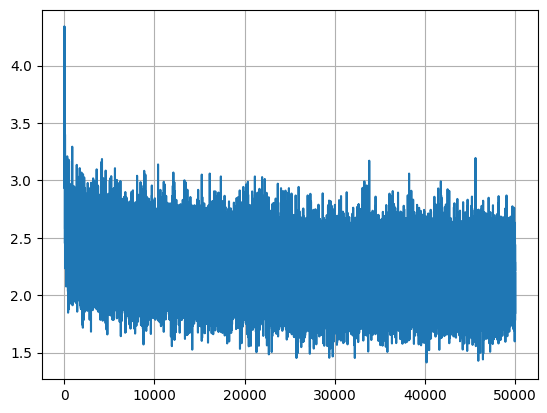

In [239]:
plt.plot(lossi)
plt.grid(True)

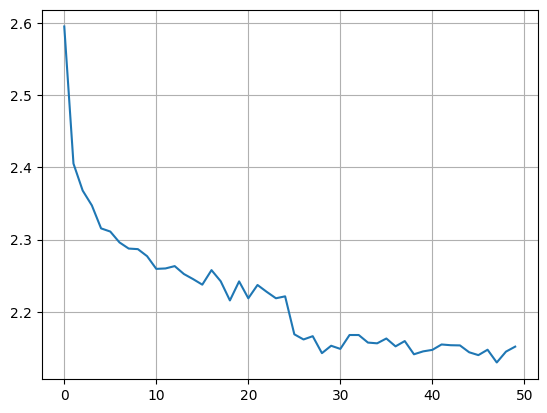

In [240]:
plt.plot(
    torch.FloatTensor(lossi).view(-1, 1000).mean(dim=1)
)
plt.grid(True)

### A third way with torch-countainers e.g. `Sequential`

In [241]:
max_steps = 50_000
batch_size = 32
lossi = []

In [242]:
model = Sequential(
        layers = [
            Embedding(num_embeddings=vocab_size, embedding_dim=n_embed),
            Flatten(),
            Linear(fan_in=num_blocks * n_embed, fan_out=n_hidden, bias=True),
            BatchNorm1d(dim=n_hidden),
            Tanh(),
            Linear(fan_in=n_hidden, fan_out=vocab_size, bias=True),    
        ]
)

parameters = model.parameters()

for p in parameters:
    p.requires_grad = True

In [243]:
# # testing: 
# u = [p for p in model.layers[-1].weights][0][0]
# u.requires_grad

In [244]:
model.layers

In [245]:
for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(len_data)[:batch_size]
    # print(f"{ix = }")
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    logits = model(Xb)    
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update rule: 
    lr = 0.1 if (i < max_steps * 0.5) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # stats
    if (i + 1) % (max_steps // 50) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
        
    # store loss
    lossi.append(loss.detach().item())


   1000 /   50000; 2.1744
   2000 /   50000; 2.3153
   3000 /   50000; 2.3325
   4000 /   50000; 2.2376
   5000 /   50000; 2.0982
   6000 /   50000; 2.1318
   7000 /   50000; 2.1048
   8000 /   50000; 2.4964
   9000 /   50000; 2.8310
  10000 /   50000; 2.4731
  11000 /   50000; 2.1941
  12000 /   50000; 2.3048
  13000 /   50000; 2.4038
  14000 /   50000; 2.0569
  15000 /   50000; 2.1795
  16000 /   50000; 2.1415
  17000 /   50000; 2.2142
  18000 /   50000; 2.3112
  19000 /   50000; 2.1593
  20000 /   50000; 2.5096
  21000 /   50000; 2.3521
  22000 /   50000; 2.1481
  23000 /   50000; 2.0136
  24000 /   50000; 2.3121
  25000 /   50000; 2.3230
  26000 /   50000; 2.2941
  27000 /   50000; 1.8849
  28000 /   50000; 2.3125
  29000 /   50000; 1.8158
  30000 /   50000; 2.0769
  31000 /   50000; 2.3559
  32000 /   50000; 2.0836
  33000 /   50000; 2.0505
  34000 /   50000; 1.9411
  35000 /   50000; 1.7328
  36000 /   50000; 2.0102
  37000 /   50000; 2.2210
  38000 /   50000; 2.2322
  39000 /   

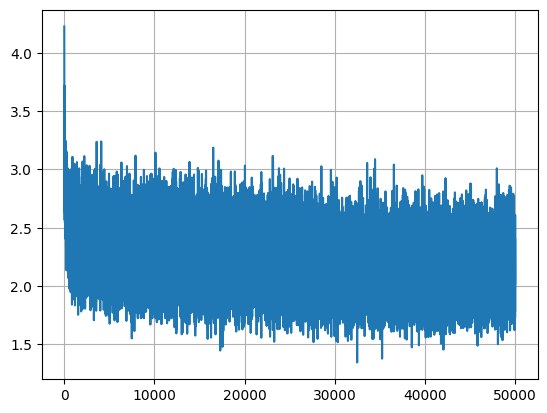

In [246]:
plt.plot(lossi)
plt.grid(True)

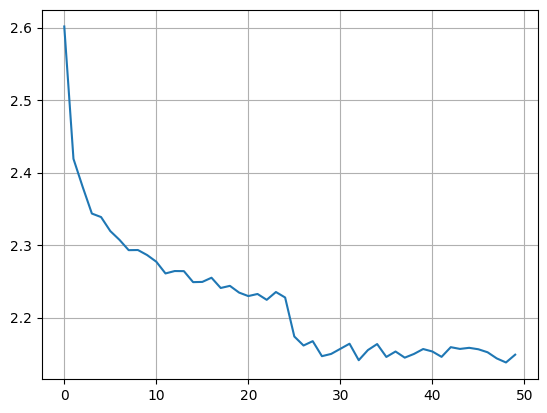

In [247]:
plt.plot(
    torch.FloatTensor(lossi[:max_steps]).view(-1, 1000).mean(dim=1)
)
plt.grid(True)

### evaluate the model

In [248]:
for layer in model.layers:
    layer.training = False

In [249]:
@torch.no_grad()
def split_eval(split: str, model):

    _data_map = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }


    x, y = _data_map[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)

    return loss

In [250]:
for split in ["train", "val", "test"]:
    print(f"{split}: {split_eval(split, model)}")

train: 2.121131658554077
val: 2.1418724060058594
test: 2.1484196186065674


### sample from the model

In [251]:
for i in range(20):
    out = []
    
    context = [0] * num_blocks
    while True:
        # x = torch.tensor(context).reshape(1, 3)
        x = torch.tensor([context])
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=rg)
        ch = itos[ix.item()]
        # print(ch)  
        context = context[1:] + [ix]
        out.append(ix)
    
        if ix == 0:
            break
    
    print(i, "".join(itos[i.item()] for i in out))
    

0 aryus.
1 ven.
2 kaylan.
3 jassa.
4 rexalivan.
5 jashailari.
6 criv.
7 mikkalynd.
8 jeian.
9 emowthoh.
10 sylia.
11 aszi.
12 mairichnya.
13 julyn.
14 kar.
15 nakameem.
16 breka.
17 evanise.
18 aarian.
19 jazvita.


### `FlattenConsequtive` 

In [252]:
# del model 
# del model_new

In [253]:
NUM_BLOCKS = 8
num_blocks = NUM_BLOCKS
X, Y = get_data(words, num_blocks=num_blocks)
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)
print(X_train.shape, Y_train.shape)

torch.Size([182516, 8]) torch.Size([182516])


In [254]:
Xb[:1].shape

torch.Size([1, 3])

In [255]:
torch.tensor(context).reshape(1, 3)

tensor([[20,  1,  0]])

In [256]:
torch.tensor([context]).shape

torch.Size([1, 3])

In [257]:
e = torch.randn((4, 8, 10)) # >> (4, 4, 20)

In [258]:
e.view(-1, e.shape[-2] // 2, e.shape[-1] * 2).shape

torch.Size([4, 4, 20])

In [259]:
n_embed, n_hidden

(10, 200)

In [260]:
num_var = 2

model = Sequential(
        layers = [
            Embedding(num_embeddings=vocab_size, embedding_dim=n_embed),
            
            FlattenConsequtive(num_var),
            Linear(fan_in=num_var * n_embed, fan_out=n_hidden, bias=True),
            BatchNorm1d(dim=n_hidden),
            Tanh(),

            FlattenConsequtive(num_var),
            Linear(fan_in=num_var * n_hidden, fan_out=n_hidden, bias=True),
            BatchNorm1d(dim=n_hidden),
            Tanh(),

            
            FlattenConsequtive(num_var),
            Linear(fan_in=num_var * n_hidden, fan_out=n_hidden, bias=True),
            BatchNorm1d(dim=n_hidden),
            Tanh(),

            
            Linear(fan_in=n_hidden, fan_out=vocab_size, bias=True),    
        ]
)

parameters = model.parameters()
print("number of params:", sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

number of params: 171497


In [261]:
# mini-batch construct
ix = torch.randperm(len_data)[:batch_size]
# print(f"{ix = }")
Xb, Yb = X_train[ix], Y_train[ix]
print(f"{Xb.shape = }")
print(f"{Yb.shape = }")
pred  = model(Xb)
print(f"{pred.shape = }")

Xb.shape = torch.Size([32, 8])
Yb.shape = torch.Size([32])
pred.shape = torch.Size([32, 27])


In [262]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsequtive : (32, 4, 20)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsequtive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsequtive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


In [263]:
max_steps = 50_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construct
    ix = torch.randperm(len_data)[:batch_size]
    # print(f"{ix = }")
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    logits = model(Xb)    
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update rule: 
    lr = 0.1 if (i < max_steps * 0.5) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # stats
    if (i + 1) % (max_steps // 50) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
        
    # store loss
    lossi.append(loss.detach().item())


   1000 /   50000; 2.3336
   2000 /   50000; 2.2504
   3000 /   50000; 1.8998
   4000 /   50000; 2.0437
   5000 /   50000; 2.1696
   6000 /   50000; 2.0973
   7000 /   50000; 2.9646
   8000 /   50000; 2.0549
   9000 /   50000; 2.1954
  10000 /   50000; 2.3330
  11000 /   50000; 2.1790
  12000 /   50000; 2.0063
  13000 /   50000; 2.2696
  14000 /   50000; 2.0964
  15000 /   50000; 1.8965
  16000 /   50000; 1.9680
  17000 /   50000; 1.9722
  18000 /   50000; 2.2885
  19000 /   50000; 2.1842
  20000 /   50000; 2.3697
  21000 /   50000; 2.4158
  22000 /   50000; 1.9604
  23000 /   50000; 2.2763
  24000 /   50000; 2.2805
  25000 /   50000; 1.9590
  26000 /   50000; 1.8178
  27000 /   50000; 2.0093
  28000 /   50000; 1.7634
  29000 /   50000; 2.2420
  30000 /   50000; 1.9183
  31000 /   50000; 1.7797
  32000 /   50000; 2.3280
  33000 /   50000; 2.4761
  34000 /   50000; 1.8583
  35000 /   50000; 1.7638
  36000 /   50000; 1.8600
  37000 /   50000; 2.1052
  38000 /   50000; 2.0819
  39000 /   

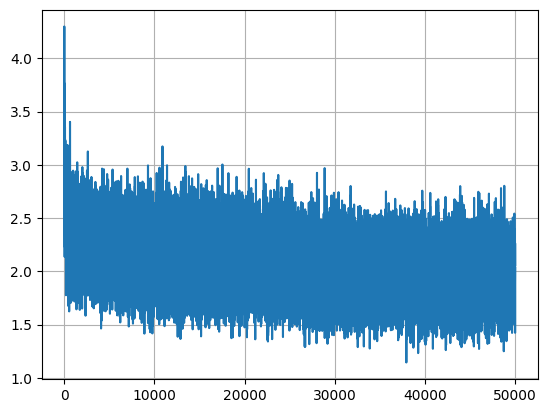

In [264]:
plt.plot(lossi)
plt.grid(True)

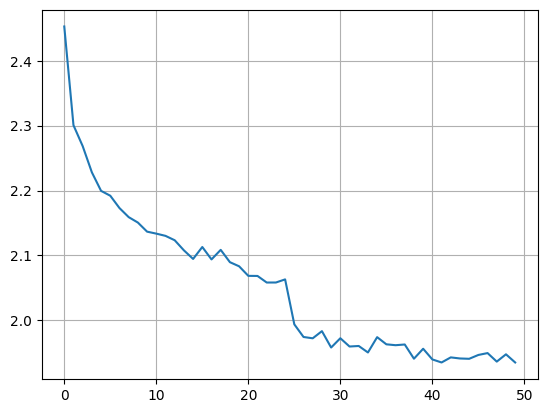

In [265]:
plt.plot(
    torch.FloatTensor(lossi[:max_steps]).view(-1, 1000).mean(dim=1)
)
plt.grid(True)

In [266]:
for split in ["train", "val", "test"]:
    print(f"{split}: {split_eval(split, model)}")

train: 1.9101569652557373
val: 2.028693675994873
test: 2.0027260780334473
